In [1]:
# Standard python libraries
from pathlib import Path
import os
import requests
import pickle
import matplotlib.pyplot as plt
# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import copy
import xgboost as xgb

from ipywidgets import interact

import shap
shap.initjs()

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

from lightautoml.addons.interpretation import SSWARM

## 1. [Catboost tutorial](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Catboost%20tutorial.html#Catboost-tutorial)

In [2]:
from catboost import CatBoostClassifier, CatBoostRegressor
X, y = shap.datasets.california(n_points=500)
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X, y, verbose=False, plot=False)

explainer_default = shap.TreeExplainer(model)
shap_values_default = explainer_default(X).values


In [3]:
df_train = X.assign(target=y)

roles = {
    'target': "target"
}

automl = TabularAutoML(
    task = Task("reg"), 
    timeout = 100,
    cpu_limit = 4,
    reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 77},
)
automl.fit_predict(df_train, roles = roles, verbose = 0)

explainer_sswarm = SSWARM(automl, random_state=77)
shap_values_sswarm = explainer_sswarm.shap_values(df_train, T=1000, n_jobs=4)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 129.80it/s]


#### Default beeswarm plot

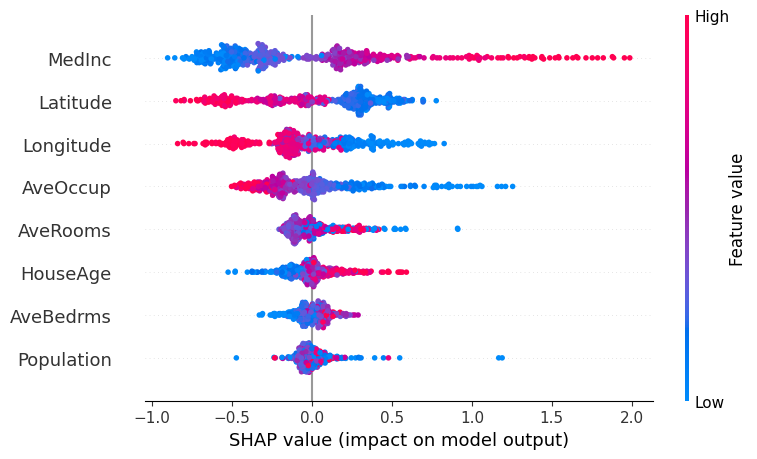

In [4]:
shap.summary_plot(shap_values_default, X)

#### SSWARM beeswarm plot

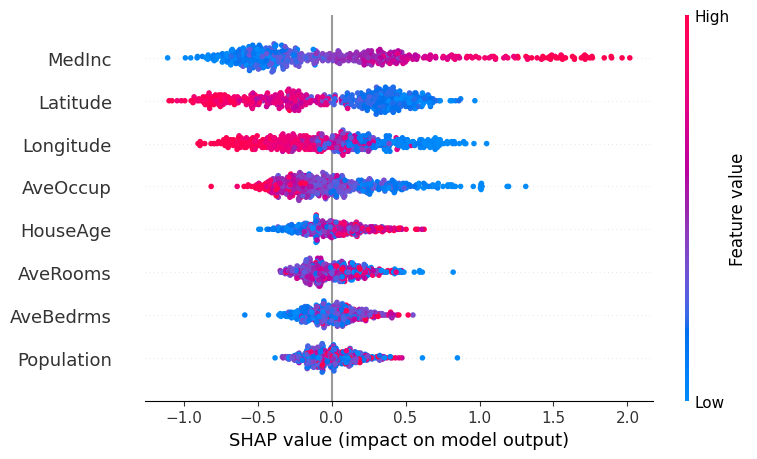

In [5]:
shap.summary_plot(shap_values_sswarm, X[explainer_sswarm.used_feats])

#### Dependence plots 

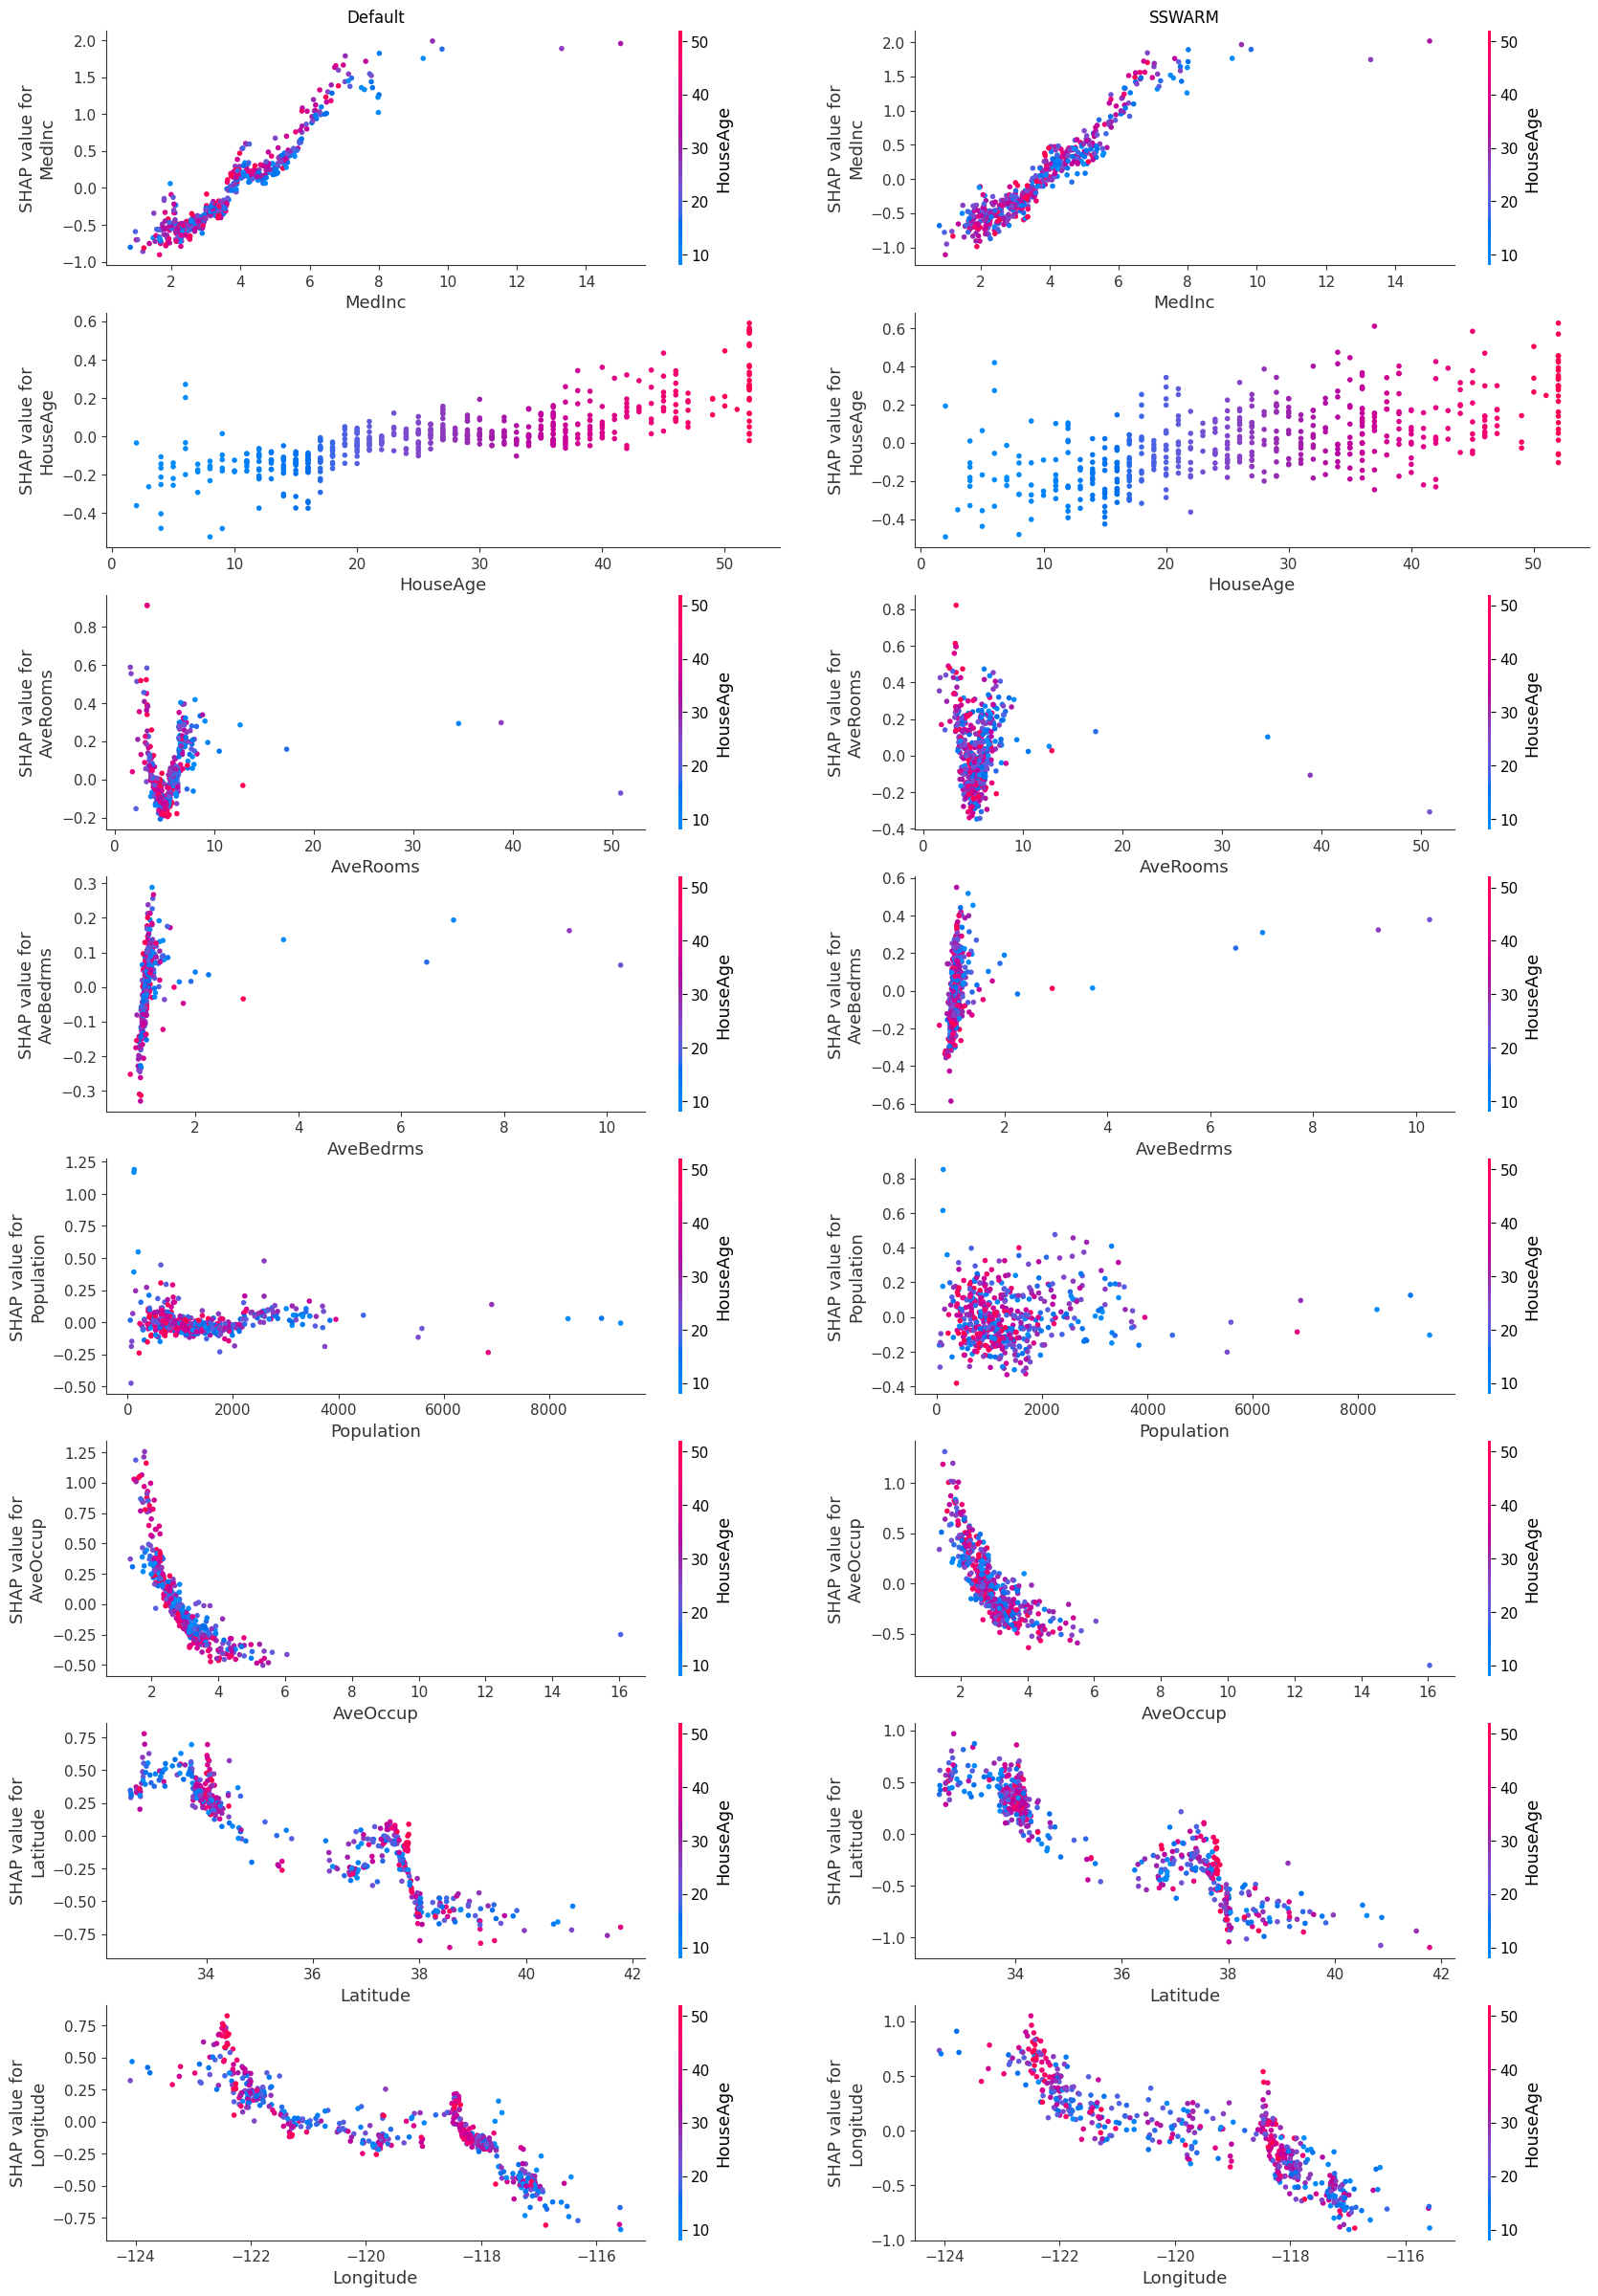

In [6]:
num_rows = X.shape[1]
fig, ax = plt.subplots(num_rows, 2, figsize=(20, 30))
ax[0][0].set_title('Default')
ax[0][1].set_title('SSWARM')
for i, feature in enumerate(X.columns):
    shap.dependence_plot(feature, shap_values_default, X, ax=ax[i][0], show=False, interaction_index="HouseAge")
    shap.dependence_plot(feature, shap_values_sswarm, X[explainer_sswarm.used_feats], ax=ax[i][1], show=False, interaction_index="HouseAge")
fig.show()

#### Force plots

In [7]:
# DEFAULT
shap.plots.force(explainer_default.expected_value, shap_values_default, X)

In [8]:
# SSWARM
shap.plots.force(explainer_sswarm.expected_value, shap_values_sswarm, X[explainer_sswarm.used_feats])

#### Individual force plots

In [9]:
@interact
def show_force_plots(i=np.arange(5)):
    a = shap.plots.force(explainer_default.expected_value, shap_values_default[i],
                                X.iloc[i], matplotlib=True, show=False)
    a.axes[0].set_ylabel("Default", fontsize=20)
    b = shap.plots.force(explainer_sswarm.expected_value, shap_values_sswarm[i],
                                X[explainer_sswarm.used_feats].iloc[i], matplotlib=True, show=False)
    b.axes[0].set_ylabel("SSWARM", fontsize=20)

    a.show(); b.show(); plt.show(); plt.clf()

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_classes=('w…

## 2. [Census income](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html)

In [10]:
import lightgbm as lgb

In [11]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [12]:

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
}

model = lgb.train(
    params,
    d_train,
    10000,
    valid_sets=[d_test],
)
explainer_default = shap.TreeExplainer(model, data=X_train.sample(500), feature_perturbation="interventional", model_output="probability")
shap_values_default = explainer_default.shap_values(X_test)

Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's binary_logloss: 0.530915
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.513733
[3]	valid_0's binary_logloss: 0.498824
[4]	valid_0's binary_logloss: 0.485607
[5]	valid_0's binary_logloss: 0.473667
[6]	valid_0's binary_logloss: 0.463023
[7]	valid_0's binary_logloss: 0.4534
[8]	valid_0's binary_logloss: 0.444444
[9]	valid_0's binary_logloss: 0.436411
[10]	valid_0's binary_logloss: 0.428679
[11]	valid_0's binary_logloss: 0.421856
[12]	valid_0's binary_logloss: 0.415378
[13]	valid_0's binary_logloss: 0.409536
[14]	valid_0's binary_logloss: 0.404116
[15]	valid_0's binary_logloss: 0.398999
[16]	valid_0's binary_logloss: 0.394169
[17]	valid_0's binary_logloss: 0.389559
[18]	valid_0's binary_logloss: 0.385387
[19]	valid_0's binary_logloss: 0.381257
[20]	valid_0's binary_logloss: 0.377656
[21]	valid_0's binary_logloss: 0.374036
[22]	valid_0's binary_logloss: 0.370661
[23]	valid_0's binary_logloss: 0.367658
[24]	valid_0's binary_logloss:

 99%|===================| 6460/6513 [01:40<00:00]        

In [13]:
df_train = X_train.assign(target=y_train)

roles = {
    'target': "target"
}

automl = TabularAutoML(
    task = Task("binary"), 
    timeout = 150,
    cpu_limit = 4,
    reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 77},
)
automl.fit_predict(df_train, roles = roles, verbose = 1)

explainer_sswarm = SSWARM(automl, random_state=77)
shap_values_sswarm = explainer_sswarm.shap_values(X_test.assign(target=y_test), T=1000, n_jobs=4)

[16:09:41] Stdout logging level is INFO.
[16:09:41] Task: binary

[16:09:41] Start automl preset with listed constraints:
[16:09:41] - time: 150.00 seconds
[16:09:41] - CPU: 4 cores
[16:09:41] - memory: 16 GB

[16:09:41] Train data shape: (26048, 13)

[16:09:48] Layer 1 train process start. Time left 143.46 secs
[16:09:50] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[16:09:57] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9263287071746517
[16:09:57] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[16:09:57] Time left 134.19 secs

[16:09:59] Selector_LightGBM fitting and predicting completed
[16:10:01] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[16:10:09] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9285587643831887
[16:10:09] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[16:10:09] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.64 secs
[16:10:13] Hyperparameters optimization for Lvl_0_P

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:11<00:00,  7.94it/s]


#### Beeswarm plot

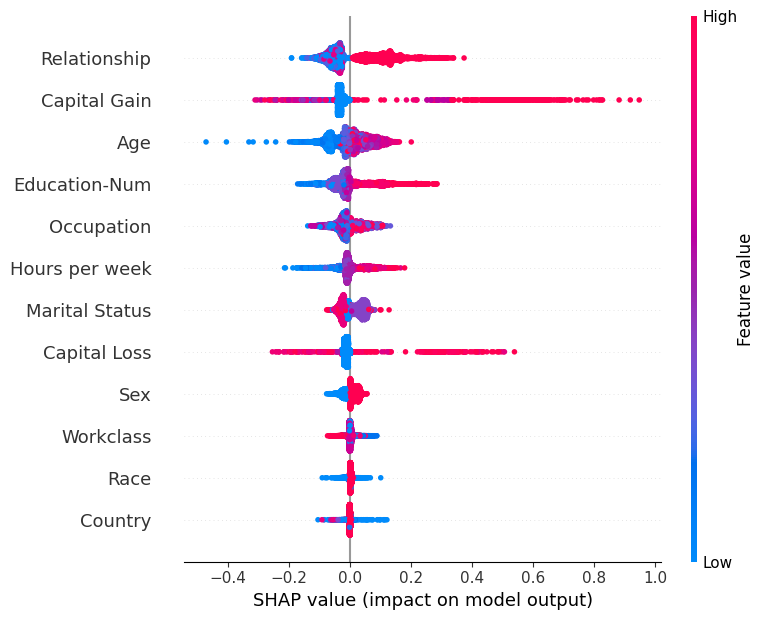

In [14]:
# Default
shap.summary_plot(shap_values_default, X_test)

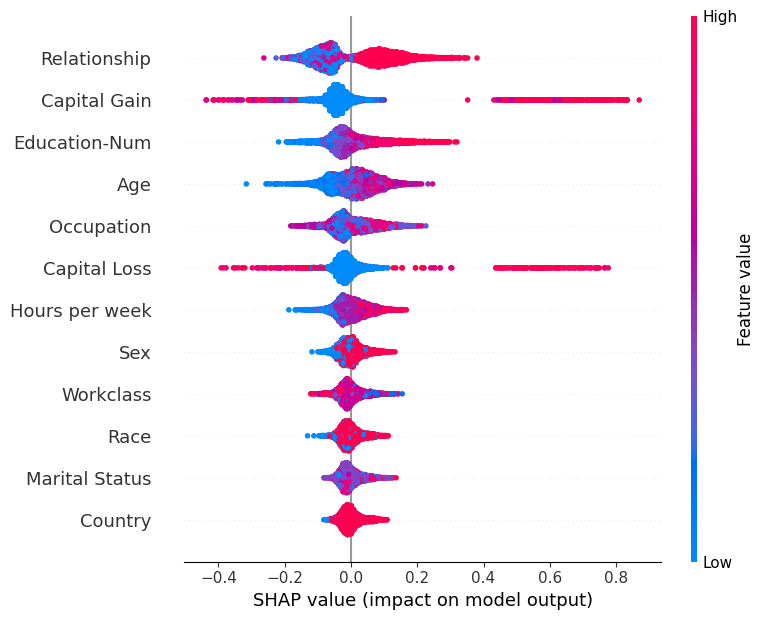

In [15]:
# SSWARM
shap.summary_plot(shap_values_sswarm[1], X_test[explainer_sswarm.used_feats])

In [20]:
num_rows = X_test.shape[1]
fig, ax = plt.subplots(num_rows, 2, figsize=(20, 50))
ax[0][0].set_title('Default')
ax[0][1].set_title('SSWARM')
for i, feature in enumerate(X_test.columns):
    shap.dependence_plot(feature, shap_values_default, X_test, ax=ax[i][0], show=False, interaction_index="Age")
    shap.dependence_plot(feature, shap_values_sswarm[1], X_test[explainer_sswarm.used_feats], ax=ax[i][1], show=False, interaction_index="Age")
fig.show()

<Figure size 640x480 with 0 Axes>

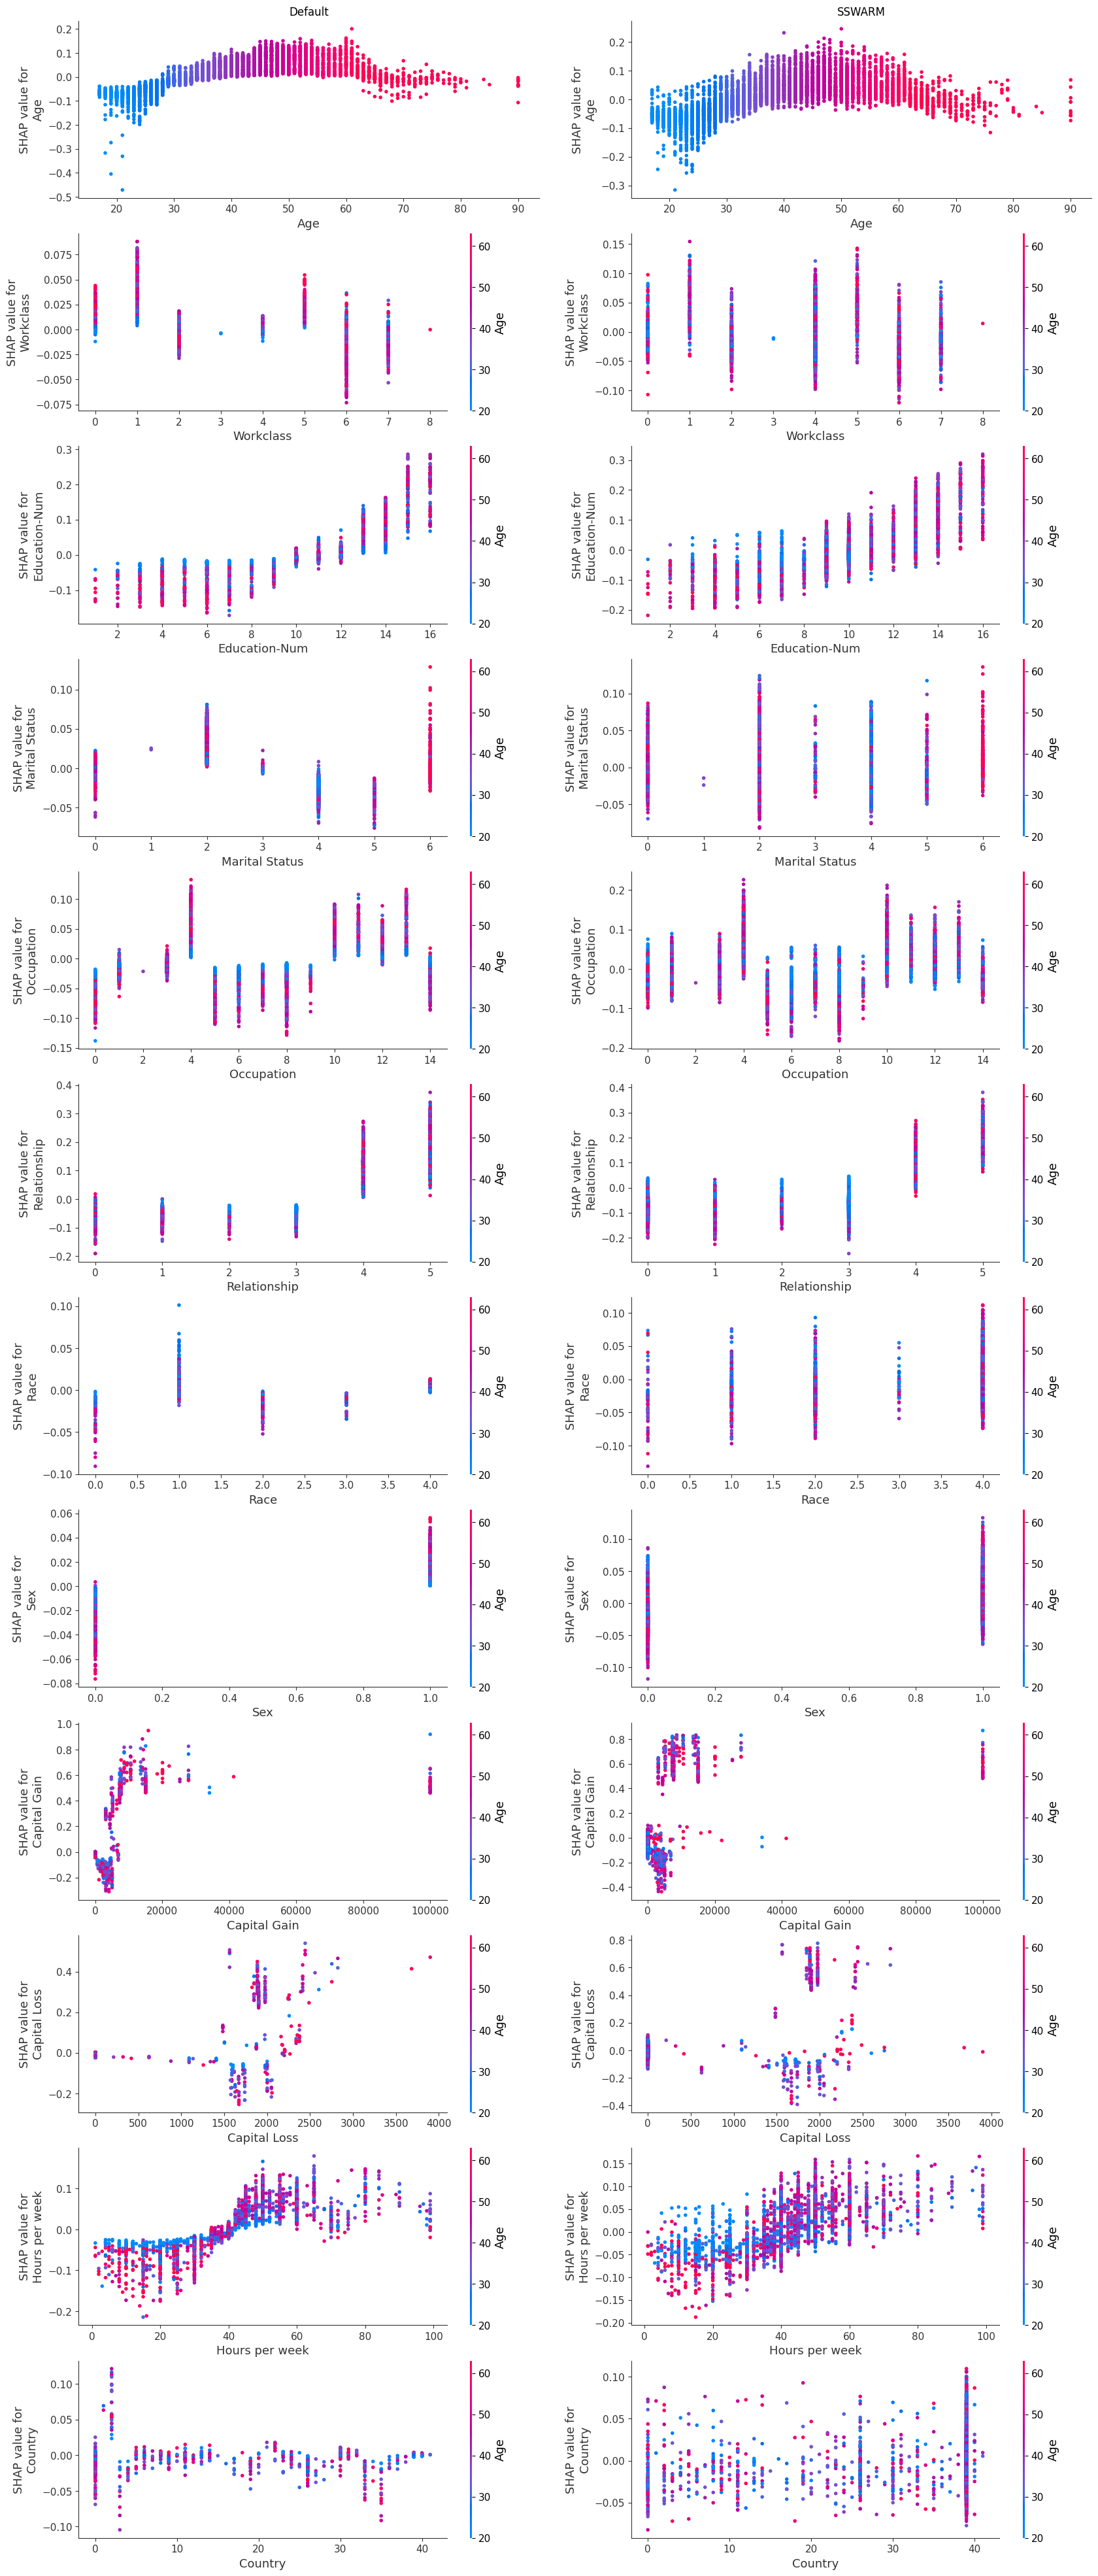

In [21]:
plt.show()

#### Force plots

In [17]:
# DEFAULT
shap.plots.force(explainer_default.expected_value, shap_values_default[:1000, :], X_test.iloc[:1000])

In [18]:
# SSWARM
shap.plots.force(explainer_sswarm.expected_value[1], shap_values_sswarm[1, :1000, :], X_test[explainer_sswarm.used_feats].iloc[:1000])

#### Individual force plots

In [22]:
@interact
def show_force_plots(i=np.arange(5)):
    a = shap.plots.force(explainer_default.expected_value, shap_values_default[i],
                                X_test.iloc[i], matplotlib=True, show=False)
    a.axes[0].set_ylabel("Default", fontsize=20)
    b = shap.plots.force(explainer_sswarm.expected_value[1], shap_values_sswarm[1][i],
                                X_test[explainer_sswarm.used_feats].iloc[i], matplotlib=True, show=False)
    b.axes[0].set_ylabel("SSWARM", fontsize=20)

    a.show(); b.show(); plt.show(); plt.clf()

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_classes=('w…

## 3. [League of Legends Win Prediction with XGBoost](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html)

In [54]:
# read in the data
folder_path = Path("/home/pbelonovskiy/kaggle/LeagueOfLegends")
matches = pd.read_csv(folder_path / "matches.csv")
participants = pd.read_csv(folder_path / "participants.csv")
stats1 = pd.read_csv(folder_path / "stats1.csv", low_memory=False)
stats2 = pd.read_csv(folder_path / "stats2.csv", low_memory=False)
stats = pd.concat([stats1, stats2])

# merge into a single DataFrame
a = pd.merge(
    participants, matches, left_on="matchid", right_on="id", suffixes=("", "_matches")
)
allstats_orig = pd.merge(
    a, stats, left_on="matchid", right_on="id", suffixes=("", "_stats")
)
allstats = allstats_orig.copy()

# drop games that lasted less than 10 minutes
allstats = allstats.loc[allstats["duration"] >= 10 * 60, :]

# Convert string-based categories to numeric values
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    allstats[c] = allstats[c].astype("category")
    allstats[c] = allstats[c].cat.codes
allstats["wardsbought"] = allstats["wardsbought"].astype(np.int32)

X = allstats.drop(columns=["win"])
y = allstats["win"]

# convert all features we want to consider as rates
rate_features = [
    "kills",
    "deaths",
    "assists",
    "killingsprees",
    "doublekills",
    "triplekills",
    "quadrakills",
    "pentakills",
    "legendarykills",
    "totdmgdealt",
    "magicdmgdealt",
    "physicaldmgdealt",
    "truedmgdealt",
    "totdmgtochamp",
    "magicdmgtochamp",
    "physdmgtochamp",
    "truedmgtochamp",
    "totheal",
    "totunitshealed",
    "dmgtoobj",
    "timecc",
    "totdmgtaken",
    "magicdmgtaken",
    "physdmgtaken",
    "truedmgtaken",
    "goldearned",
    "goldspent",
    "totminionskilled",
    "neutralminionskilled",
    "ownjunglekills",
    "enemyjunglekills",
    "totcctimedealt",
    "pinksbought",
    "wardsbought",
    "wardsplaced",
    "wardskilled",
]
for feature_name in rate_features:
    X[feature_name] /= X["duration"] / 60  # per minute rate

# convert to fraction of game
X["longesttimespentliving"] /= X["duration"]

# define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets",
}
feature_names = [full_names.get(n, n) for n in X.columns]
X.columns = feature_names

# create train/validation split
Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

In [76]:
params = {
    "objective": "binary:logistic",
    "base_score": np.mean(yt),
    "eval_metric": "logloss",
}
model = xgb.train(
    params,
    dt,
    num_boost_round=100,
    evals=[(dt, "train"), (dv, "valid")],
    early_stopping_rounds=5,
    verbose_eval=25,
)
# compute the SHAP values for every prediction in the validation dataset
explainer_default = shap.TreeExplainer(model, data=Xt.sample(500), feature_perturbation="interventional", model_output="probability")
shap_values_default = explainer_default.shap_values(Xv.sample(30000, random_state=77))

[0]	train-logloss:0.57283	valid-logloss:0.57286
[25]	train-logloss:0.27057	valid-logloss:0.27227
[50]	train-logloss:0.22596	valid-logloss:0.22973
[75]	train-logloss:0.20137	valid-logloss:0.20638
[99]	train-logloss:0.18336	valid-logloss:0.18951


[15:43:21] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 29844/30000 [03:23<00:01]        

In [62]:
df_train = Xt.assign(target=yt)

roles = {
    'target': "target"
}

automl = TabularAutoML(
    task = Task("binary"), 
    timeout = 500,
    cpu_limit = 8,
    reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 77},
)
automl.fit_predict(df_train, roles = roles, verbose = 4)

explainer_sswarm = SSWARM(automl, random_state=77)
shap_values_sswarm = explainer_sswarm.shap_values(X_test.assign(target=y_test), T=1000, n_jobs=8)

[14:13:50] Stdout logging level is DEBUG.
[14:13:50] Task: binary

[14:13:50] Start automl preset with listed constraints:
[14:13:50] - time: 500.00 seconds
[14:13:50] - CPU: 8 cores
[14:13:50] - memory: 16 GB

[14:13:50] Train data shape: (1229705, 72)

[14:14:03] Feats was rejected during automatic roles guess: []
[14:14:03] Layer 1 train process start. Time left 487.29 secs
[14:15:51] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:15:51] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [86], 'embed_sizes': array([6], dtype=int32), 'data_size': 87}
[14:15:51] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[14:15:57] Linear model: C = 1e-05 score = 0.9317961975632099
[14:16:04] Linear model: C = 5e-05 score = 0.9409185217303586
[14:16:10] Linear model: C = 0.0001 score = 0.9439231631863064


AttributeError: 'numpy.ndarray' object has no attribute 'assign'

In [65]:
explainer_sswarm = SSWARM(automl, random_state=77)
shap_values_sswarm = explainer_sswarm.shap_values(Xv.assign(target=yv).sample(30000, random_state=77), T=1000, n_jobs=8)


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [47:25<00:00,  1.42s/it]


### Beeswarm plot

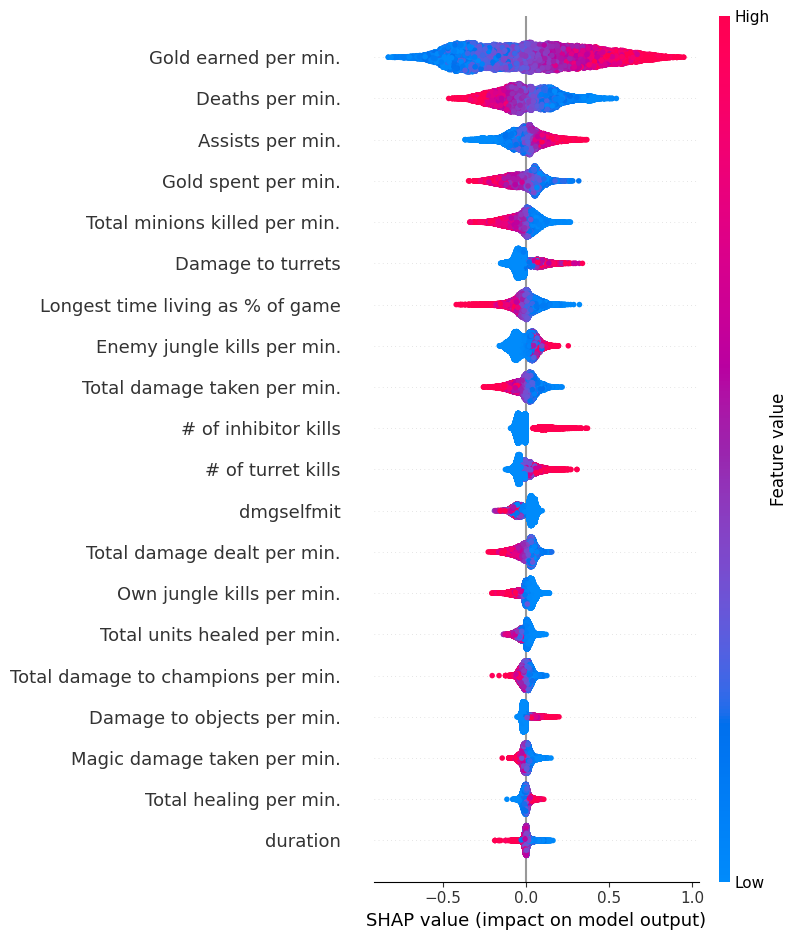

In [77]:
shap.summary_plot(shap_values_default, Xv.sample(30000, random_state=77))

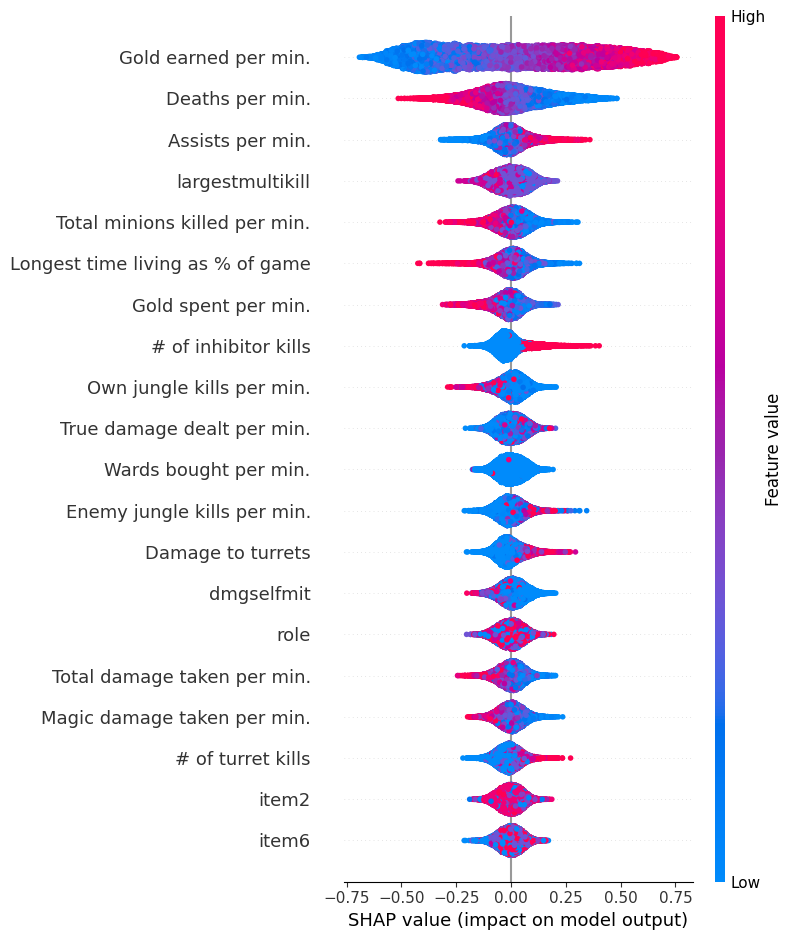

In [75]:
shap.summary_plot(shap_values_sswarm[1], Xv[explainer_sswarm.used_feats].sample(30000, random_state=77))

In [92]:
num_rows = 20
fig, ax = plt.subplots(num_rows, 2, figsize=(20, 50))
ax[0][0].set_title('Default')
ax[0][1].set_title('SSWARM')
for i, feature in enumerate(explainer_sswarm.used_feats[:num_rows]):
    shap.dependence_plot(feature, shap_values_default, Xv.sample(30000,random_state=77), ax=ax[i][0], show=False, interaction_index="Gold earned per min.")
    shap.dependence_plot(feature, shap_values_sswarm[1], Xv[explainer_sswarm.used_feats].sample(30000,random_state=77), ax=ax[i][1], show=False, interaction_index="Gold earned per min.")
fig.show()

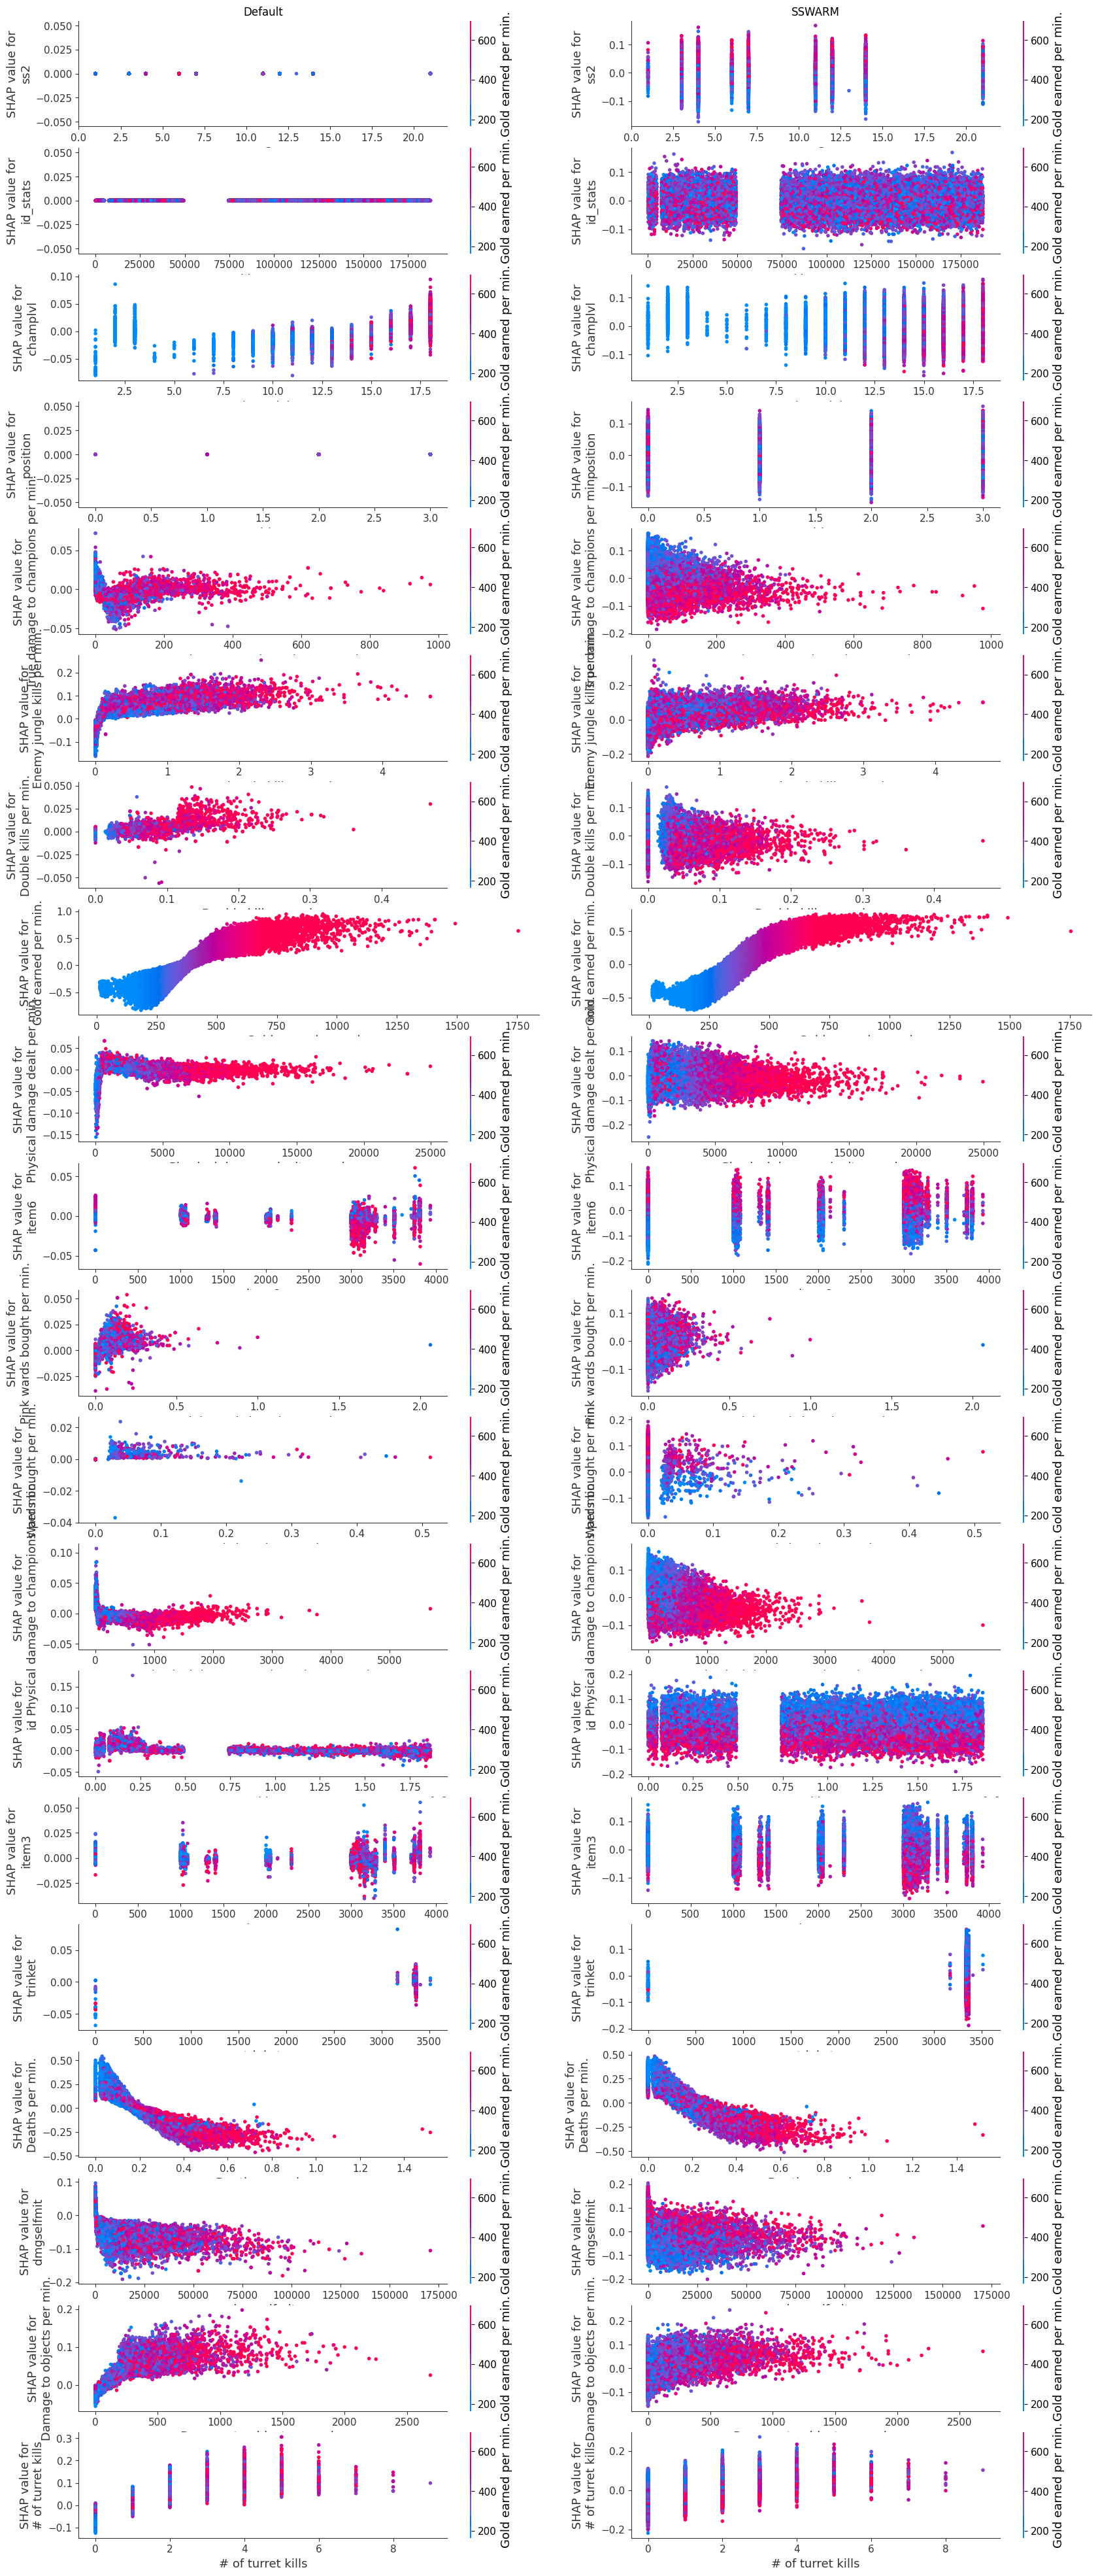

In [93]:
plt.show()